In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
BATCH_SIZE = 128
IMAGE_SIZE = 28

In [4]:
Transforms = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root="C:/Users/Arun/pytorch/datasets", train=True, download=True, transform=Transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.normal_(mean=0.0, std=0.1)

    def flatten_input(self, inputs):
        # Flatten the input tensor while maintaining the batch size and embedding dimension
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # shape: (B, H, W, C)
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)  # shape: (B * H * W, C)
        return inputs, flat_input, input_shape

    def compute_distances(self, flat_input):
        # Compute squared L2 distances between the input and embeddings efficiently
        emb_weights = self.embeddings.weight  # shape: (num_embeddings, embedding_dim)
        distances = (
            torch.sum(flat_input**2, dim=1, keepdim=True)  # shape: (B * H * W, 1)
            + torch.sum(emb_weights**2, dim=1)  # shape: (num_embeddings,)
            - 2 * torch.matmul(flat_input, emb_weights.t())  # shape: (B * H * W, num_embeddings)
        )
        return distances

    def get_encoding_indices(self, distances):
        # Get the indices of the nearest embeddings
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # shape: (B * H * W, 1)
        return encoding_indices

    def quantize(self, encoding_indices, input_shape):
        # Generate one-hot encodings and compute quantized vectors
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=encoding_indices.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        quantized = torch.matmul(encodings, self.embeddings.weight)  # shape: (B * H * W, embedding_dim)
        quantized = quantized.view(input_shape)  # Reshape to (B, H, W, embedding_dim)
        return quantized

    def compute_loss(self, quantized, inputs):
        # Compute the VQ-VAE loss efficiently
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        return loss

    def forward(self, inputs):
        # Process the input through the VQ-VAE pipeline
        inputs, flat_input, input_shape = self.flatten_input(inputs)
        distances = self.compute_distances(flat_input)
        encoding_indices = self.get_encoding_indices(distances)
        quantized = self.quantize(encoding_indices, input_shape)
        
        # Compute the loss and add gradients to the encoder
        loss = self.compute_loss(quantized, inputs)
        quantized = inputs + (quantized - inputs).detach()  # Gradient passthrough
        
        # Re-permute the quantized output back to (B, C, H, W)
        return quantized.permute(0, 3, 1, 2).contiguous(), loss



class SimpleVQVAE(nn.Module):
    def __init__(self, embedding_dim=64 ,num_embeddings=10):
        super(SimpleVQVAE, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, embedding_dim, kernel_size=1)
        )
        
        # Vector Quantizer
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost=0.5)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=1),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss = self.vq_layer(z)
        reconstructed = self.decoder(quantized)
        return reconstructed, vq_loss
vqvae = SimpleVQVAE().to(device)
print(vqvae)

SimpleVQVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (vq_layer): VectorQuantizer(
    (embeddings): Embedding(10, 64)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (5): Tanh()
  )
)


In [6]:
from torchsummary import summary
a=summary(vqvae, input_size=(1, 28, 28),device=device.type)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       544
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       32,832
|    └─ReLU: 2-4                         --
|    └─Conv2d: 2-5                       4,160
├─VectorQuantizer: 1-2                   --
|    └─Embedding: 2-6                    640
├─Sequential: 1-3                        --
|    └─ConvTranspose2d: 2-7              65,600
|    └─ReLU: 2-8                         --
|    └─ConvTranspose2d: 2-9              32,800
|    └─ReLU: 2-10                        --
|    └─ConvTranspose2d: 2-11             33
|    └─Tanh: 2-12                        --
Total params: 136,609
Trainable params: 136,609
Non-trainable params: 0


Loaded checkpoint from epoch 30


C:\Users\Arun\AppData\Local\Temp\ipykernel_22064\4255299386.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


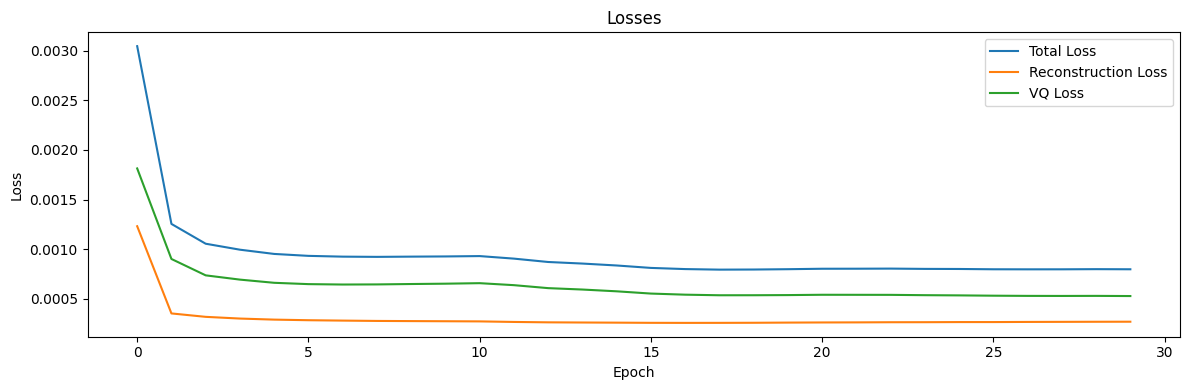

In [7]:
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

def save_checkpoint(model, optimizer, epoch, loss_history, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    checkpoint_path = os.path.join(save_dir, f"vqvae_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history
    }, checkpoint_path)

def load_checkpoint(model, optimizer, save_dir, epoch=None):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if epoch is None:
        checkpoints = [f for f in os.listdir(save_dir) if f.startswith("vqvae_epoch_") and f.endswith(".pth")]
        if not checkpoints:
            print("No checkpoints found. Starting from scratch.")
            return 0, []
        
        latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("_")[-1].split(".")[0]))
        checkpoint_path = os.path.join(save_dir, latest_checkpoint)
    else:
        checkpoint_path = os.path.join(save_dir, f"vqvae_epoch_{epoch}.pth")
    
    if not os.path.exists(checkpoint_path):
        print(f"No checkpoint found at {checkpoint_path}. Starting from scratch.")
        return 0, []
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']
    
    print(f"Loaded checkpoint from epoch {epoch}")
    return epoch, loss_history

def train_vqvae(vqvae, dataloader, epochs=20, device="cpu", save_dir="checkpoints", resume_epoch=None):
    optimizer = optim.Adam(vqvae.parameters(), lr=1e-3)
    
    loss_history = {'total_loss': [], 'recons_loss': [], 'vq_loss': []}
    
    start_epoch, loss_history = load_checkpoint(vqvae, optimizer, save_dir, resume_epoch)
    
    
    
    for epoch in range(start_epoch, epochs):
        epoch_loss = 0
        epoch_recons_loss = 0
        epoch_vq_loss = 0

        with tqdm(enumerate(dataloader, start=1), total=len(dataloader), unit="batch") as t:
            for batch_idx, (images, _) in t:
                optimizer.zero_grad()
                images = images.to(device)
                recon_images, vq_loss = vqvae(images)
                recon_loss = F.mse_loss(recon_images, images)
                loss = recon_loss + vq_loss
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                epoch_recons_loss += recon_loss.item()
                epoch_vq_loss += vq_loss.item()
                
                t.set_description(f'Epoch [{epoch+1}/{epochs}]')
                t.set_postfix({'Train loss': f'{epoch_loss/batch_idx:.3f}', 
                               'Batch loss': f'{loss:.3f}', 
                               'Recon loss': f'{recon_loss:.3f}', 
                               'vq_loss':f'{vq_loss:.3f}'})

        epoch_size = len(dataloader.dataset)
        loss_history['total_loss'].append(epoch_loss / epoch_size)
        loss_history['recons_loss'].append(epoch_recons_loss / epoch_size)
        loss_history['vq_loss'].append(epoch_vq_loss / epoch_size)

        save_checkpoint(vqvae, optimizer, epoch + 1, loss_history, save_dir)

    return loss_history


# To start or resume training:
loss_history = train_vqvae(vqvae, train_loader, epochs=30, device=device, save_dir="checkpoints")

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Plot losses
ax.plot(loss_history['total_loss'], label='Total Loss')
ax.plot(loss_history['recons_loss'], label='Reconstruction Loss')
ax.plot(loss_history['vq_loss'], label='VQ Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Losses')
ax.legend()

plt.tight_layout()
plt.show()


In [8]:
loss_history

{'total_loss': [0.003043816297252973,
  0.0012541879010697205,
  0.0010547909919172524,
  0.000994669893880685,
  0.0009519641072799762,
  0.0009325153520951668,
  0.0009246731236577034,
  0.0009224309033403794,
  0.0009247952174395323,
  0.0009267099103579919,
  0.0009303040313223998,
  0.0009047406168033679,
  0.0008708446718752385,
  0.0008550239724417528,
  0.0008356577078501384,
  0.0008112073050191005,
  0.000799479195723931,
  0.000793889998147885,
  0.000794977455213666,
  0.0007982452136774858,
  0.0008028001025319099,
  0.0008031518902629614,
  0.0008042528241872787,
  0.000801359668870767,
  0.0008004609820743402,
  0.0007974546348055204,
  0.000796903030325969,
  0.0007971017379313708,
  0.0007986675982673963,
  0.0007974863418688376],
 'recons_loss': [0.001230975617095828,
  0.00035295515035589533,
  0.0003185039741297563,
  0.0003012917997936408,
  0.0002906183319787184,
  0.0002845688865830501,
  0.00028071346047023934,
  0.0002773634383454919,
  0.00027575553450733426,


In [9]:
# Test function
def test_vae(model, dataloader, num_images=10, device="cpu"):
    model.eval()
    inputs, outputs = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            img, _ = batch
            img = img.to(device)

            recons, _ = model(img)
            inputs.append(img.cpu())
            outputs.append(recons.cpu())
            if len(inputs) * img.size(0) >= num_images:
                break
    
    inputs = torch.cat(inputs)[:num_images]
    outputs = torch.cat(outputs)[:num_images]
    
    return inputs, outputs


def plot_reconstructions(inputs, outputs, num_images=10):
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(num_images * 2.5, 6))
    
    for i in range(num_images):
        # Original image
        axes[0, i].imshow(inputs[i].squeeze(), cmap='gray', aspect='auto')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original', fontsize=12, color='blue')
        
        # Reconstructed image
        axes[1, i].imshow(outputs[i].squeeze(), cmap='gray', aspect='auto')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed', fontsize=12, color='green')
    
    plt.suptitle('Original vs Reconstructed Images', fontsize=16, color='darkred')
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to fit main title
    plt.show()

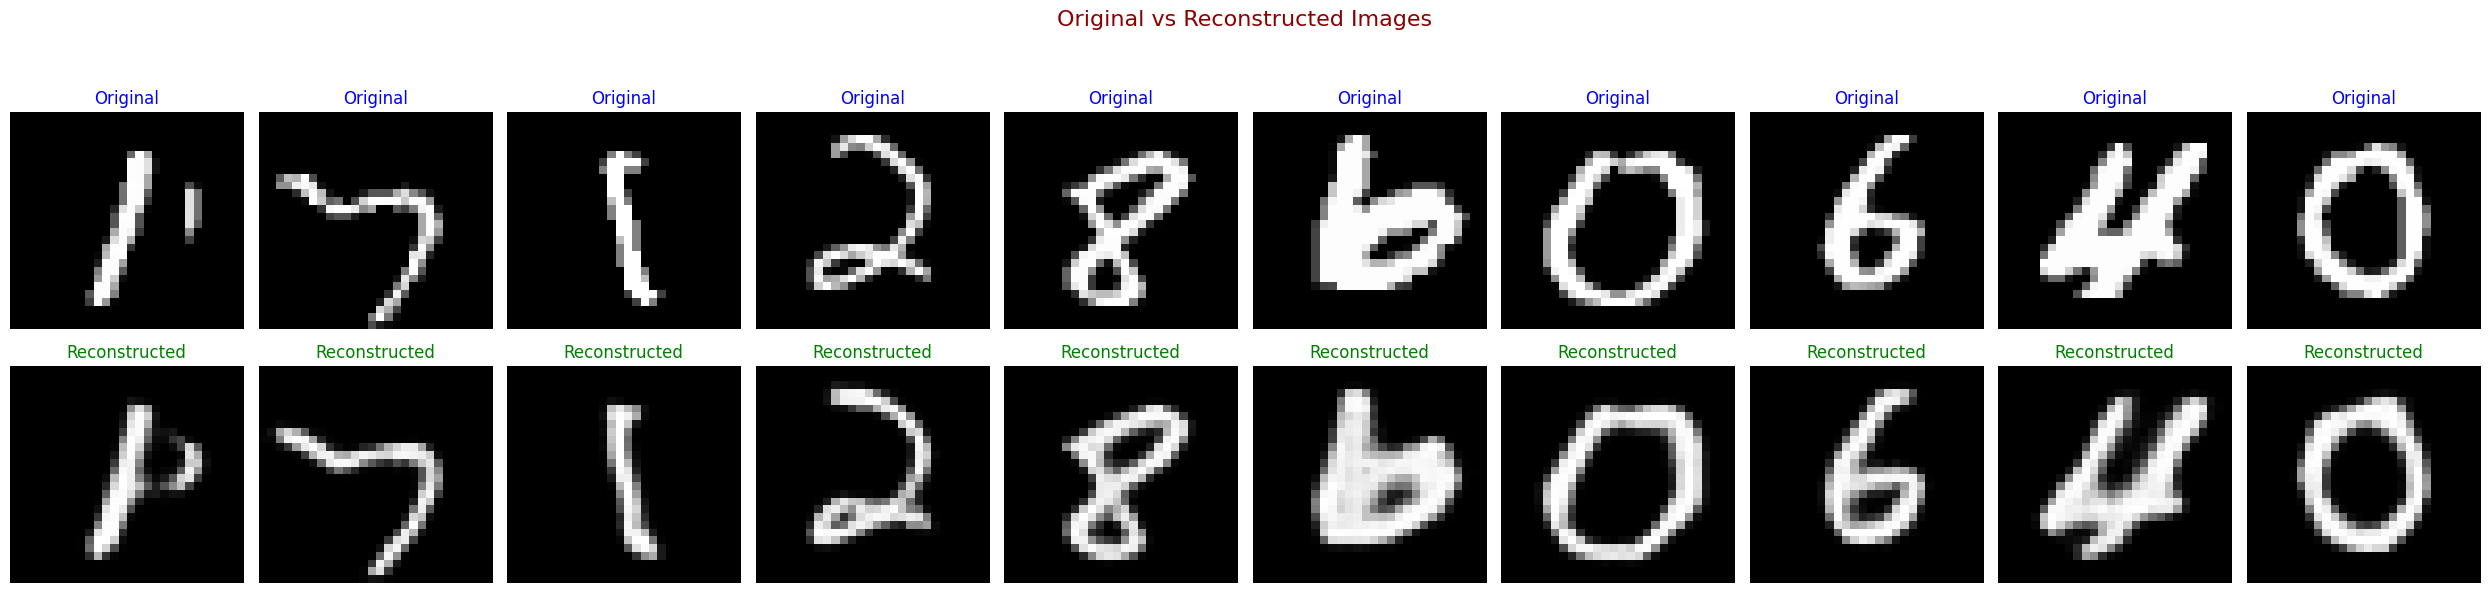

In [10]:
# Test the VAE model
inputs, outputs = test_vae(vqvae, test_loader, num_images=10, device=device)

# Plot the original and reconstructed images
plot_reconstructions(inputs, outputs, num_images=10)

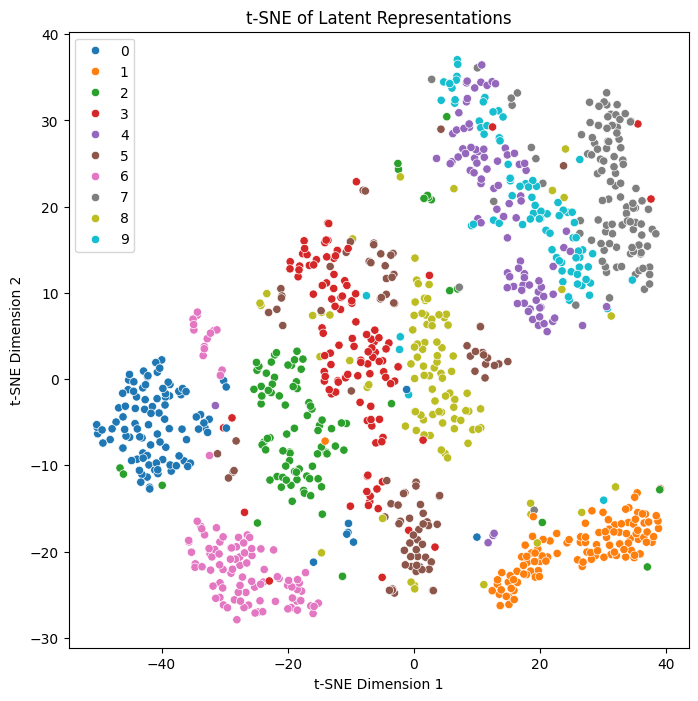

In [11]:
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_latent_space(model, dataloader, device="cpu", num_samples=1000):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            images, lbls = batch
            images = images.to(device)
            z = model.encoder(images)
            latent_representations.append(z.view(z.size(0), -1).cpu().numpy())
            labels.append(lbls.cpu().numpy())
            if len(latent_representations) * images.size(0) >= num_samples:
                break
    
    latent_representations = np.concatenate(latent_representations)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]
    
    # Reduce dimensions with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(latent_representations)
    
    # Plot the t-SNE results
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette="tab10", legend="full")
    plt.title('t-SNE of Latent Representations')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Visualize the latent space using t-SNE
visualize_latent_space(vqvae, test_loader, device=device, num_samples=1000)


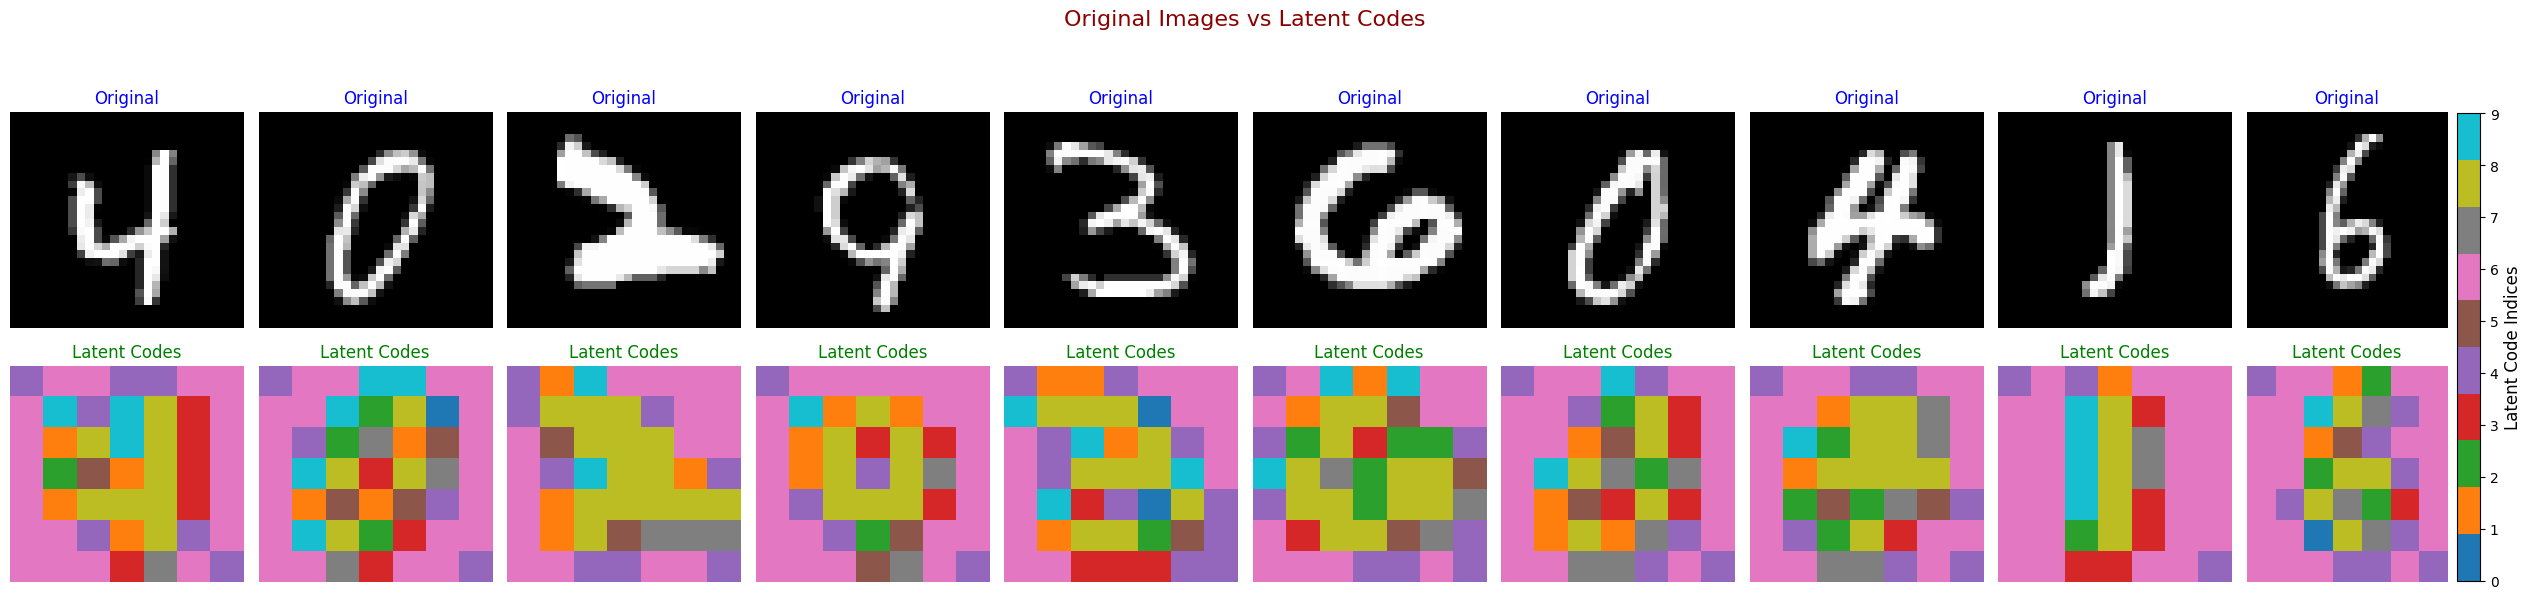

In [12]:
import seaborn as sns

def plot_original_vs_latent_codes(model, dataloader, num_images=10, device="cpu"):
    model.eval()
    inputs, latent_indices = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            img, _ = batch
            img = img.to(device)

            # Get the latent codes
            z = model.encoder(img)
            _, flat_input, input_shape = model.vq_layer.flatten_input(z)
            distances = model.vq_layer.compute_distances(flat_input)
            encoding_indices = model.vq_layer.get_encoding_indices(distances)
            encoding_indices = encoding_indices.view(input_shape[:-1]).cpu()
            
            inputs.append(img.cpu())
            latent_indices.append(encoding_indices)
            if len(inputs) * img.size(0) >= num_images:
                break
    
    inputs = torch.cat(inputs)[:num_images]
    latent_indices = torch.cat(latent_indices)[:num_images]
    
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(num_images * 2.5, 6))

    # Get Seaborn's Set2 colormap
    cmap = sns.color_palette("tab10", n_colors=model.vq_layer.num_embeddings, as_cmap=True)
    
    for i in range(num_images):
        # Original image
        axes[0, i].imshow(inputs[i].squeeze(), cmap='gray', aspect='auto')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original', fontsize=12, color='blue')
        
        # Latent code indices
        img_plot = axes[1, i].imshow(latent_indices[i].squeeze(), cmap=cmap, aspect='auto', vmin=0, vmax=model.vq_layer.num_embeddings - 1)
        axes[1, i].axis('off')
        axes[1, i].set_title('Latent Codes', fontsize=12, color='green')
    
    plt.suptitle('Original Images vs Latent Codes', fontsize=16, color='darkred')
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to fit main title
    
    # Add a color bar to show the scale of the colormap
    cbar = fig.colorbar(img_plot, ax=axes[:, num_images-1], fraction=0.1, pad=0.04)
    cbar.set_label('Latent Code Indices', fontsize=12)
    
    plt.show()

# Visualize original images vs latent codes
plot_original_vs_latent_codes(vqvae, test_loader, num_images=10, device=device)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        self.mask.fill_(1)
        _, _, height, width = self.weight.size()
        self.mask[:, :, height // 2, width // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, height // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        self.conv2 = MaskedConv2d('B', in_channels // 2, in_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels // 2, in_channels, kernel_size=1)

    def forward(self, x):
        residual = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return F.relu(x + residual)

class PixelCNN(nn.Module):
    def __init__(self, input_shape, num_embeddings, num_residual_blocks, num_pixelcnn_layers):
        super(PixelCNN, self).__init__()
        self.num_embeddings = num_embeddings
        self.ohe_layer = nn.Embedding(num_embeddings, num_embeddings)
        self.ohe_layer.weight.data = torch.eye(num_embeddings)

        self.initial_conv = MaskedConv2d('A', num_embeddings, 128, kernel_size=7, padding=3)
        self.residual_blocks = nn.ModuleList([ResidualBlock(128) for _ in range(num_residual_blocks)])
        self.pixelcnn_layers = nn.ModuleList([MaskedConv2d('B', 128, 128, kernel_size=1) for _ in range(num_pixelcnn_layers)])
        self.conv_out = nn.Conv2d(128, num_embeddings, kernel_size=1)

    def forward(self, x):
        x = self.ohe_layer(x).permute(0, 3, 1, 2).float()
        x = F.relu(self.initial_conv(x))
        for block in self.residual_blocks:
            x = block(x)
        for layer in self.pixelcnn_layers:
            x = F.relu(layer(x))
        return self.conv_out(x)


In [14]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        self.mask.fill_(1)
        _, _, kH, kW = self.weight.size()
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class GatedPixelConvLayer(nn.Module):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        super(GatedPixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = MaskedConv2d(mask_type, in_channels, 2 * out_channels, kernel_size, **kwargs)

    def forward(self, x):
        out = self.conv(x)
        out1, out2 = torch.chunk(out, 2, dim=1)
        return torch.sigmoid(out1) * torch.tanh(out2)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pixel_conv = GatedPixelConvLayer(
            mask_type='B',
            in_channels=out_channels,
            out_channels=out_channels // 2,
            kernel_size=3,
            padding=1
        )
        self.conv2 = nn.Conv2d(out_channels // 2, in_channels, kernel_size=1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        residual = x
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.pixel_conv(x))
        x = torch.relu(self.conv2(x))
        x = self.dropout(x)
        return x + residual

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

class PixelCNN(nn.Module):
    def __init__(self, input_shape, num_embeddings, num_residual_blocks, num_pixelcnn_layers):
        super(PixelCNN, self).__init__()
        self.input_shape = input_shape
        self.num_embeddings = num_embeddings

        self.ohe_layer = nn.Embedding(num_embeddings, num_embeddings)
        self.pixel_conv_A = GatedPixelConvLayer(
            mask_type='A',
            in_channels=num_embeddings,
            out_channels=128,
            kernel_size=7,
            padding=3
        )

        self.residual_blocks = nn.ModuleList([
            ResidualBlock(128, 128) for _ in range(num_residual_blocks)
        ])

        self.pixel_conv_B_layers = nn.ModuleList([
            GatedPixelConvLayer(
                mask_type='B',
                in_channels=128,
                out_channels=128,
                kernel_size=1
            ) for _ in range(num_pixelcnn_layers)
        ])

        self.self_attention = SelfAttention(128)
        self.bn = nn.BatchNorm2d(128)
        self.conv_out = nn.Conv2d(128, num_embeddings, kernel_size=1)

    def forward(self, x):
        x = self.ohe_layer(x).permute(0, 3, 1, 2)
        x = torch.relu(self.pixel_conv_A(x))

        for block in self.residual_blocks:
            x = block(x)

        for layer in self.pixel_conv_B_layers:
            x = torch.relu(layer(x))

        x = self.self_attention(x)
        x = self.bn(x)
        return self.conv_out(x)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class GatedMaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        super(GatedMaskedConv2d, self).__init__(in_channels, 2 * out_channels, kernel_size, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        self.mask.fill_(1)
        _, _, height, width = self.weight.size()
        self.mask[:, :, height // 2, width // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, height // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        out = super(GatedMaskedConv2d, self).forward(x)
        out1, out2 = torch.chunk(out, 2, dim=1)
        return torch.sigmoid(out1) * torch.tanh(out2)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        self.conv2 = GatedMaskedConv2d('B', in_channels // 2, in_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels // 2, in_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(in_channels // 2)
        self.bn2 = nn.BatchNorm2d(in_channels // 2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(F.relu(self.bn2(self.conv2(x))))
        x = self.conv3(x)
        return F.relu(x + residual)

class PixelCNN(nn.Module):
    def __init__(self, input_shape, num_embeddings, num_residual_blocks, num_pixelcnn_layers):
        super(PixelCNN, self).__init__()
        self.num_embeddings = num_embeddings
        self.ohe_layer = nn.Embedding(num_embeddings, num_embeddings)
        self.ohe_layer.weight.data = torch.eye(num_embeddings)

        self.initial_conv = GatedMaskedConv2d('A', num_embeddings, 128, kernel_size=7, padding=3)
        self.residual_blocks = nn.ModuleList([ResidualBlock(128) for _ in range(num_residual_blocks)])
        self.pixelcnn_layers = nn.ModuleList([GatedMaskedConv2d('B', 128, 128, kernel_size=1) for _ in range(num_pixelcnn_layers)])
        self.conv_out = nn.Conv2d(128, num_embeddings, kernel_size=1)

    def forward(self, x):
        x = self.ohe_layer(x).permute(0, 3, 1, 2).float()
        x = F.relu(self.initial_conv(x))
        for block in self.residual_blocks:
            x = block(x)
        for layer in self.pixelcnn_layers:
            x = F.relu(layer(x))
        return self.conv_out(x)



In [16]:
class GatedMaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding=0, **kwargs):
        super(GatedMaskedConv2d, self).__init__(in_channels, 2 * out_channels, kernel_size, padding=padding, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        self.mask.fill_(1)
        _, _, height, width = self.weight.size()
        self.mask[:, :, height // 2, width // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, height // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        out = super(GatedMaskedConv2d, self).forward(x)
        out1, out2 = torch.chunk(out, 2, dim=1)
        return torch.sigmoid(out1) * torch.tanh(out2)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        self.conv2 = GatedMaskedConv2d('B', in_channels // 2, in_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels // 2, in_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(in_channels // 2)
        self.bn2 = nn.BatchNorm2d(in_channels // 2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(F.relu(self.bn2(self.conv2(x))))
        x = self.conv3(x)
        return F.relu(x + residual)

class PixelCNN(nn.Module):
    def __init__(self, input_shape, num_embeddings, num_residual_blocks, num_pixelcnn_layers):
        super(PixelCNN, self).__init__()
        self.num_embeddings = num_embeddings
        self.ohe_layer = nn.Embedding(num_embeddings, num_embeddings)
        self.ohe_layer.weight.data = torch.eye(num_embeddings)

        self.initial_conv = GatedMaskedConv2d('A', num_embeddings, 128, kernel_size=7, padding=3)
        self.residual_blocks = nn.ModuleList([ResidualBlock(128) for _ in range(num_residual_blocks)])
        self.pixelcnn_layers = nn.ModuleList([GatedMaskedConv2d('B', 128, 128, kernel_size=1) for _ in range(num_pixelcnn_layers)])
        self.conv_out = nn.Conv2d(128, num_embeddings, kernel_size=1)

    def forward(self, x):
        x = self.ohe_layer(x).permute(0, 3, 1, 2).float()
        x = F.relu(self.initial_conv(x))
        for block in self.residual_blocks:
            x = block(x)
        for layer in self.pixelcnn_layers:
            x = F.relu(layer(x))
        return self.conv_out(x)

In [17]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}, "mask_type should be either 'A' or 'B'"
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        self.mask.fill_(1)
        _, _, height, width = self.weight.size()
        yc, xc = height // 2, width // 2
        self.mask[:, :, yc, xc + (self.mask_type == 'B'):] = 0
        self.mask[:, :, yc + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class GatedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mask_type):
        super(GatedResidualBlock, self).__init__()
        self.conv1 = MaskedConv2d(mask_type, in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = MaskedConv2d('B', out_channels, out_channels, kernel_size=3, padding=1)
        self.gate = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        residual = self.residual(x)
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        gate = torch.sigmoid(self.gate(x))
        return gate * x + residual

class PixelSNAIL(nn.Module):
    def __init__(self, num_codebook_vectors, embedding_dim, hidden_channels=64, num_blocks=8):
        super(PixelSNAIL, self).__init__()
        self.num_codebook_vectors = num_codebook_vectors
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_codebook_vectors, embedding_dim)

        
        self.initial_conv = MaskedConv2d('A', embedding_dim, hidden_channels, kernel_size=3, padding=1)
        self.blocks = nn.ModuleList([GatedResidualBlock(hidden_channels, hidden_channels, 'B') for _ in range(num_blocks)])
        self.output_conv = nn.Conv2d(hidden_channels, num_codebook_vectors, kernel_size=1)
    
    def forward(self, x):
        x = self.embedding(x).permute(0, 3, 1, 2).float()
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        x = self.output_conv(x)
        return x

# # Example usage with masking
# model_with_mask = PixelSNAIL(input_channels, num_codebook_vectors)
# output_with_mask = model_with_mask(dummy_input)
# output_with_mask.shape


In [18]:
pixelcnn = PixelCNN((1, 7, 7), vqvae.vq_layer.num_embeddings, num_residual_blocks=2, num_pixelcnn_layers=2)
pixelcnn

PixelCNN(
  (ohe_layer): Embedding(10, 10)
  (initial_conv): GatedMaskedConv2d(10, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (residual_blocks): ModuleList(
    (0-1): 2 x ResidualBlock(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv2): GatedMaskedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (pixelcnn_layers): ModuleList(
    (0-1): 2 x GatedMaskedConv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_out): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
)

In [19]:
from torchsummary import summary
summary(pixelcnn, input_size=(1, 7, 7),device=device.type)

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         100
├─GatedMaskedConv2d: 1-2                 125,696
├─ModuleList: 1-3                        --
|    └─ResidualBlock: 2-1                --
|    |    └─Conv2d: 3-1                  8,256
|    |    └─GatedMaskedConv2d: 3-2       73,856
|    |    └─Conv2d: 3-3                  8,320
|    |    └─BatchNorm2d: 3-4             128
|    |    └─BatchNorm2d: 3-5             128
|    |    └─Dropout: 3-6                 --
|    └─ResidualBlock: 2-2                --
|    |    └─Conv2d: 3-7                  8,256
|    |    └─GatedMaskedConv2d: 3-8       73,856
|    |    └─Conv2d: 3-9                  8,320
|    |    └─BatchNorm2d: 3-10            128
|    |    └─BatchNorm2d: 3-11            128
|    |    └─Dropout: 3-12                --
├─ModuleList: 1-4                        --
|    └─GatedMaskedConv2d: 2-3            33,024
|    └─GatedMaskedConv2d: 2-4            33,024
├─Conv2d: 1-5                    

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         100
├─GatedMaskedConv2d: 1-2                 125,696
├─ModuleList: 1-3                        --
|    └─ResidualBlock: 2-1                --
|    |    └─Conv2d: 3-1                  8,256
|    |    └─GatedMaskedConv2d: 3-2       73,856
|    |    └─Conv2d: 3-3                  8,320
|    |    └─BatchNorm2d: 3-4             128
|    |    └─BatchNorm2d: 3-5             128
|    |    └─Dropout: 3-6                 --
|    └─ResidualBlock: 2-2                --
|    |    └─Conv2d: 3-7                  8,256
|    |    └─GatedMaskedConv2d: 3-8       73,856
|    |    └─Conv2d: 3-9                  8,320
|    |    └─BatchNorm2d: 3-10            128
|    |    └─BatchNorm2d: 3-11            128
|    |    └─Dropout: 3-12                --
├─ModuleList: 1-4                        --
|    └─GatedMaskedConv2d: 2-3            33,024
|    └─GatedMaskedConv2d: 2-4            33,024
├─Conv2d: 1-5                    

In [20]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}, "mask_type should be either 'A' or 'B'"
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        self.mask.fill_(1)
        _, _, height, width = self.weight.size()
        yc, xc = height // 2, width // 2
        self.mask[:, :, yc, xc + (self.mask_type == 'B'):] = 0
        self.mask[:, :, yc + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class GatedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mask_type):
        super(GatedResidualBlock, self).__init__()
        self.conv1 = MaskedConv2d(mask_type, in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = MaskedConv2d('B', out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.gate = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn_residual = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        residual = self.bn_residual(self.residual(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        gate = torch.sigmoid(self.gate(x))
        return gate * x + residual

class CausalSelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(CausalSelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        query = self.query(x).view(batch_size, channels, -1).permute(0, 2, 1)
        key = self.key(x).view(batch_size, channels, -1)
        value = self.value(x).view(batch_size, channels, -1)

        # Causal attention: masking the attention map to maintain autoregressive property
        attention = torch.bmm(query, key)
        mask = torch.tril(torch.ones(height * width, height * width)).to(attention.device)
        attention = attention.masked_fill(mask == 0, float('-inf'))
        attention = F.softmax(attention, dim=2)
        
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)

        out = self.gamma * out + x
        return out

class PixelSNAIL(nn.Module):
    def __init__(self,  num_codebook_vectors, hidden_channels=64, num_blocks=8):
        super(PixelSNAIL, self).__init__()
        self.num_codebook_vectors = num_codebook_vectors
        
        self.embedding = nn.Embedding(num_codebook_vectors, hidden_channels)
        self.initial_conv = MaskedConv2d('A', hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.blocks = nn.ModuleList([GatedResidualBlock(hidden_channels, hidden_channels, 'B') for _ in range(num_blocks)])
        self.attention = CausalSelfAttention(hidden_channels)
        self.output_conv = nn.Conv2d(hidden_channels, num_codebook_vectors, kernel_size=1)
    
    def forward(self, x):
        x = self.embedding(x).permute(0, 3, 1, 2)  # Convert embedding to (batch, channels, height, width)
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        x = self.attention(x)
        x = self.output_conv(x)
        return x


In [21]:
pixelsnail = PixelSNAIL(num_codebook_vectors= vqvae.num_embeddings,  hidden_channels= 64, num_blocks= 8 )
pixelsnail

PixelSNAIL(
  (embedding): Embedding(10, 64)
  (initial_conv): MaskedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (blocks): ModuleList(
    (0-7): 8 x GatedResidualBlock(
      (conv1): MaskedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): MaskedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (gate): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (residual): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn_residual): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (attention): CausalSelfAttention(
    (query): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (key): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (value): Conv2d(64, 64, kernel_size=(1,

In [22]:
from torchsummary import summary
a= summary(pixelsnail, input_size=(1, 7, 7),device=device.type)

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         640
├─MaskedConv2d: 1-2                      36,928
├─ModuleList: 1-3                        --
|    └─GatedResidualBlock: 2-1           --
|    |    └─MaskedConv2d: 3-1            36,928
|    |    └─BatchNorm2d: 3-2             128
|    |    └─MaskedConv2d: 3-3            36,928
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Conv2d: 3-5                  4,160
|    |    └─Conv2d: 3-6                  4,160
|    |    └─BatchNorm2d: 3-7             128
|    └─GatedResidualBlock: 2-2           --
|    |    └─MaskedConv2d: 3-8            36,928
|    |    └─BatchNorm2d: 3-9             128
|    |    └─MaskedConv2d: 3-10           36,928
|    |    └─BatchNorm2d: 3-11            128
|    |    └─Conv2d: 3-12                 4,160
|    |    └─Conv2d: 3-13                 4,160
|    |    └─BatchNorm2d: 3-14            128
|    └─GatedResidualBlock: 2-3           --
|    |    └─MaskedConv2d: 3-15  

In [23]:
# Encode the training dataset
def encode_dataset(vqvae, dataloader, device):
    vqvae.eval()
    all_indices = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc="Encoding dataset"):
            images = images.to(device)
            encoded = vqvae.encoder(images)
            _, flat_input, input_shape = vqvae.vq_layer.flatten_input(encoded)
            distances = vqvae.vq_layer.compute_distances(flat_input)
            indices = vqvae.vq_layer.get_encoding_indices(distances)
            indices = indices.view(input_shape[:-1])
            
            all_indices.append(indices.cpu())
    return torch.cat(all_indices, dim=0)

# Encode the entire dataset
encoded_dataset = encode_dataset(vqvae, train_loader, device)

print(encoded_dataset.shape)

encoded_loader = torch.utils.data.DataLoader(
    encoded_dataset, 
    batch_size=128, 
    shuffle=True, 
    num_workers=4,  # Adjust according to your CPU
    pin_memory=True
)


Encoding dataset: 100%|██████████| 469/469 [00:08<00:00, 53.51it/s]

torch.Size([60000, 7, 7])


No checkpoints found. Starting from scratch.


Epoch 40/40: 100%|██████████| 469/469 [00:13<00:00, 33.88batch/s, loss=0.612009]


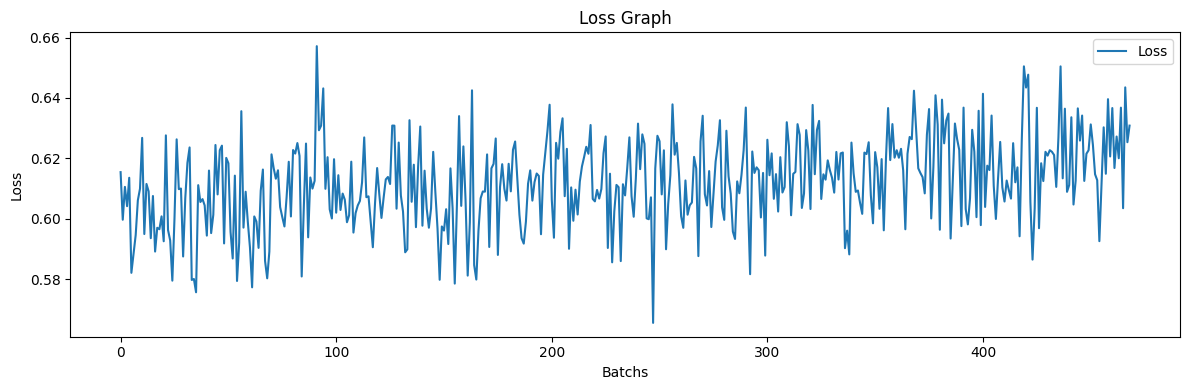

In [25]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm



def train_prior(model, dataloader, epochs, save_dir, device='cpu', resume_epoch=None): 
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = {'loss': []}
    start_epoch, loss_history = load_checkpoint(model, optimizer, save_dir, resume_epoch)
    
    
    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0
        
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            
            for batch_idx, data in enumerate(dataloader, start=1):
                data = data.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(data)
                outputs = outputs.permute(0, 2, 3, 1).contiguous()  # Convert to NHWC for loss computation
                outputs = outputs.view(-1, model.num_codebook_vectors)
                data = data.view(-1)
                
                # Compute the loss
                loss = F.cross_entropy(outputs, data)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Accumulate the running loss
                running_loss += loss.item()
                loss_history['loss'].append(loss.item())
                # Update tqdm progress bar
                pbar.set_postfix({"loss": f"{running_loss / (batch_idx):.6f}"})
                pbar.update(1)
                

        save_checkpoint(model, optimizer, epoch + 1, loss_history, save_dir)

    return loss_history

# Define the PixelSNAIL model
pixelsnail = PixelSNAIL(num_codebook_vectors=vqvae.num_embeddings, hidden_channels=64, num_blocks=8)
pixelsnail.to(device)
# To start or resume training:
loss_history = train_prior(pixelsnail, encoded_loader, epochs=40, save_dir="checkpoints_prior", device=device)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Plot losses
ax.plot(loss_history['loss'], label='Loss')
ax.set_xlabel('Batchs')
ax.set_ylabel('Loss')
ax.set_title('Loss Graph')
ax.legend()

plt.tight_layout()
plt.show()

In [34]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def generate_latent_codes(model, shape, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        latent_codes = torch.zeros(shape, dtype=torch.long, device=device)  # Initialize latent codes
        progress_bar = tqdm(total=shape[1] * shape[2], desc="Generating latent codes")

        for i in range(shape[1]):  # Iterate over height
            for j in range(shape[2]):  # Iterate over width
                output = model(latent_codes)  # Forward pass to get logits
                probs = F.softmax(output[:, :, i, j], dim=1)  # Convert logits to probabilities
                latent_codes[:, i, j] = probs.argmax(dim=1)  # Select the most likely index
                progress_bar.update(1)  # Update progress bar

        progress_bar.close()  # Close progress bar
    return latent_codes  # Return the generated latent codes

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_latent_codes = generate_latent_codes(pixelsnail, (64, 7, 7), device)

print(new_latent_codes.shape)

Generating latent codes: 100%|██████████| 49/49 [00:00<00:00, 64.95it/s]

torch.Size([64, 7, 7])


In [35]:

def generate_latent_codes(model, shape, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        latent_codes = torch.zeros(shape, dtype=torch.long, device=device)  # Initialize latent codes
        progress_bar = tqdm(total=shape[1]*shape[2], desc="Generating latent codes")
        
        for i in range(shape[1]):  # Iterate over height
            for j in range(shape[2]):  # Iterate over width
                output = model(latent_codes)  # Forward pass to get logits
                probs = F.softmax(output[:, :, i, j], dim=1)  # Convert logits to probabilities
                latent_codes[:, i, j] = torch.multinomial(probs, 1).squeeze(-1)  # Sample from probabilities
                progress_bar.update(1)  # Update progress bar
                
        progress_bar.close()  # Close progress bar
    return latent_codes  # Return the generated latent codes

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# pixelcnn = PixelCNN(input_shape=(7, 7), num_embeddings=10, num_residual_blocks=5, num_pixelcnn_layers=5).to(device)
new_latent_codes = generate_latent_codes(pixelsnail, (64, 7, 7), device)


Generating latent codes: 100%|██████████| 49/49 [00:00<00:00, 58.60it/s]


In [36]:
new_latent_codes

tensor([[[4, 6, 6,  ..., 9, 4, 6],
         [6, 1, 1,  ..., 5, 8, 6],
         [6, 0, 5,  ..., 1, 7, 6],
         ...,
         [6, 2, 8,  ..., 2, 7, 6],
         [6, 4, 8,  ..., 2, 3, 6],
         [6, 6, 6,  ..., 7, 3, 4]],

        [[4, 4, 6,  ..., 4, 6, 6],
         [9, 8, 7,  ..., 2, 7, 6],
         [6, 2, 5,  ..., 8, 7, 6],
         ...,
         [6, 8, 8,  ..., 8, 8, 6],
         [6, 4, 3,  ..., 4, 8, 3],
         [6, 6, 6,  ..., 6, 3, 4]],

        [[4, 4, 1,  ..., 9, 6, 6],
         [4, 2, 8,  ..., 8, 8, 6],
         [6, 1, 2,  ..., 8, 5, 6],
         ...,
         [1, 2, 2,  ..., 8, 8, 4],
         [2, 8, 8,  ..., 5, 7, 6],
         [6, 3, 3,  ..., 6, 6, 4]],

        ...,

        [[4, 6, 4,  ..., 6, 6, 6],
         [6, 6, 1,  ..., 9, 2, 6],
         [6, 4, 2,  ..., 1, 8, 4],
         ...,
         [9, 8, 8,  ..., 8, 7, 6],
         [6, 3, 3,  ..., 5, 6, 6],
         [6, 6, 6,  ..., 7, 6, 4]],

        [[4, 6, 4,  ..., 6, 6, 6],
         [6, 6, 1,  ..., 7, 6, 6],
         [6,

In [37]:
encoded_dataset = encode_dataset(vqvae, train_loader, device)

Encoding dataset: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]


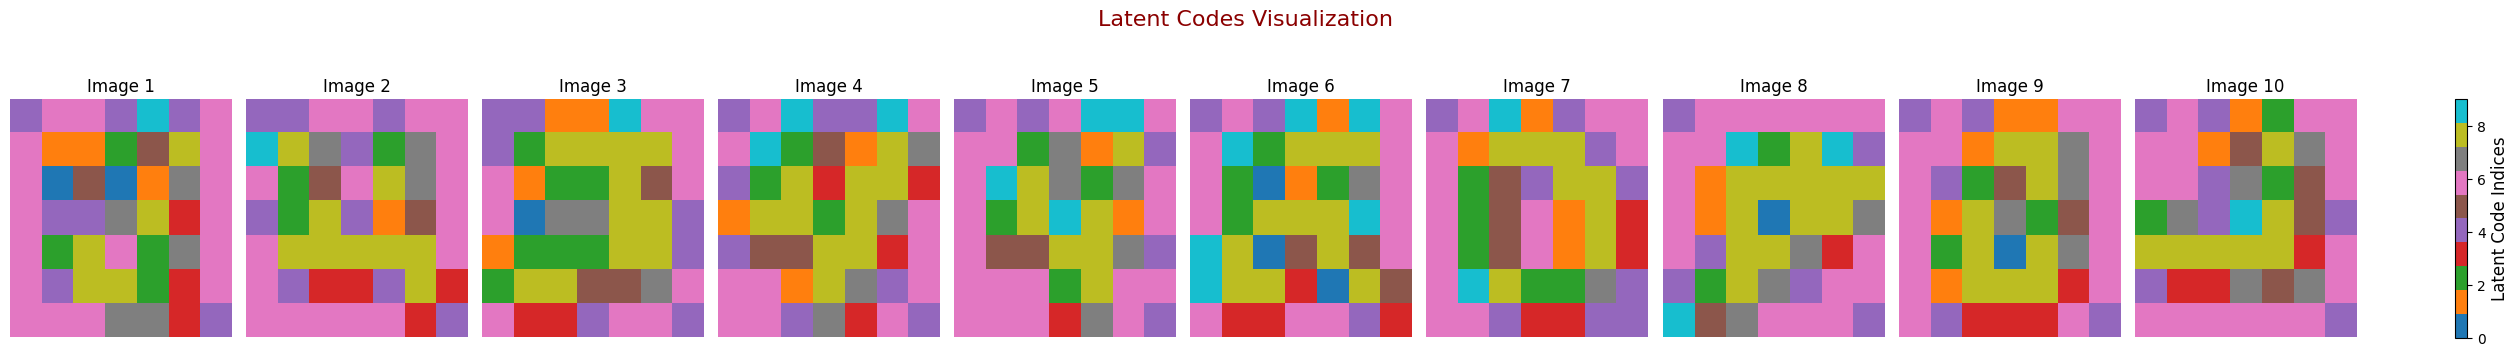

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_latent_codes(latent_codes, num_images=10):
    """
    Visualize the latent codes produced by the PixelCNN model.
    
    Args:
    - latent_codes (torch.Tensor): Tensor of latent codes of shape (batch_size, height, width).
    - num_images (int): Number of images to display.
    """
    # Ensure the latent_codes tensor is on the CPU
    latent_codes = latent_codes.cpu()
    
    # Determine the number of images to display
    num_images = min(num_images, latent_codes.size(0))
    
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images * 2.5, 3.5))

    # Get Seaborn's tab10 colormap
    cmap = sns.color_palette("tab10", n_colors=latent_codes.max().item() + 1, as_cmap=True)
    
    for i in range(num_images):
        img_plot = axes[i].imshow(latent_codes[i].squeeze(), cmap=cmap, aspect='auto', vmin=0, vmax=latent_codes.max().item())
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1}', fontsize=12)
    
    plt.suptitle('Latent Codes Visualization', fontsize=16, color='darkred')
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to fit main title
    
    # Add a color bar to show the scale of the colormap
    cbar = fig.colorbar(img_plot, ax=axes, fraction=0.01, pad=0.04)
    cbar.set_label('Latent Code Indices', fontsize=12)
    
    plt.show()

plot_latent_codes(new_latent_codes, num_images=10)


In [39]:
new_latent_codes.shape

torch.Size([64, 7, 7])

In [40]:
quantized = vqvae.vq_layer.quantize(new_latent_codes.view(-1,1), [64, 7, 7, 64])

quantized = quantized.permute(0, 3, 1, 2).contiguous()

reconstructed = vqvae.decoder(quantized)

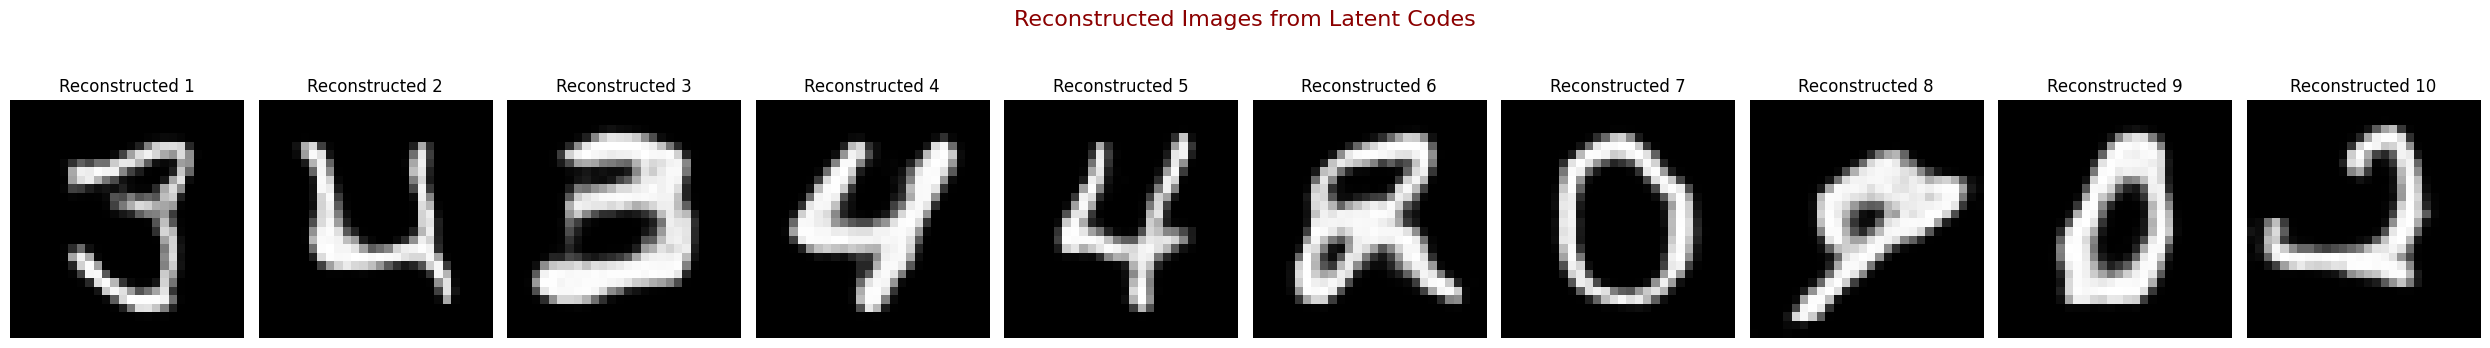

In [41]:
import matplotlib.pyplot as plt

def visualize_reconstructed_images(reconstructed_images, num_images=10):
    """
    Visualize the reconstructed images.
    
    Args:
    - reconstructed_images (torch.Tensor): Tensor of reconstructed images.
    - num_images (int): Number of images to display.
    """
    # Ensure the reconstructed_images tensor is on the CPU
    reconstructed_images = reconstructed_images.cpu().detach()
    
    # Determine the number of images to display
    num_images = min(num_images, reconstructed_images.size(0))
    
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images * 2.5, 3.5))
    
    for i in range(num_images):
        axes[i].imshow(reconstructed_images[i].permute(1, 2, 0).squeeze(), cmap='gray', aspect='auto')
        axes[i].axis('off')
        axes[i].set_title(f'Reconstructed {i+1}', fontsize=12)
    
    plt.suptitle('Reconstructed Images from Latent Codes', fontsize=16, color='darkred')
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to fit main title
    plt.show()

# Example usage
visualize_reconstructed_images(reconstructed, num_images=10)
